
# Project 3: Understanding User Behavior

<b> Created by Elizabeth Khan</b>

<b> Last updated on: 8/06/2021</b>

## Project Description
- You're a data scientist at a game development company  

- Your latest mobile game has several events you're interested in tracking: 

1. `buy a sword` 
2. `join guild`
3. `buy a shield`
4. `buy a potion`
5. `find treasure`
6. `enemy attack`
7. `defeat enemy`
8. `take potion`
9. `level up`

- Each has metadata characterstic of such events (i.e., sword type, guild name,
  etc)
  
Purchasing events such as `buy a sword`, `buy a shield`, `buy a potion` have metadata such as item_type, description, and price.

Gameplay events such as `join a guild`, `find treasure`, `defeat enemy` has description as its metadata.

Finally player status events such as `enemy attack`, `take potion` and `level up` have description, level, attack, defense, and health as metadata.


## Purpose
The purpose of this Jupyter notebook is to create an end to end data pipeline to ingest game events from mobile devices and make them available for querying to address player and game related questions. Although this data is synthetically generated mobile app data it will provide examples of potential business use cases for our game development company.

Through this we will be able to address the following game specific questions via querying from Presto.

1. How many swords, shields, and potions were purchased?
2. How many members are in each guild?
3. What is are the levels of the top 10 players?
4. How many enemies did a player defeat?
5. Which player used the most potions?
6. Which player found the most treasures?
7. How many players were attacked by an enemy?


## Deliverables

- docker-compose.yml file ([here](docker-compose.yml))
- game_api.py file ([here](game_api.py))
- Jupyter Notebook (this notebook)
- write_events_stream.py file ([here](write_events_stream.py))
- data_generator.sh  ([here](data_generator.sh))



# Data Pipeline Architecture


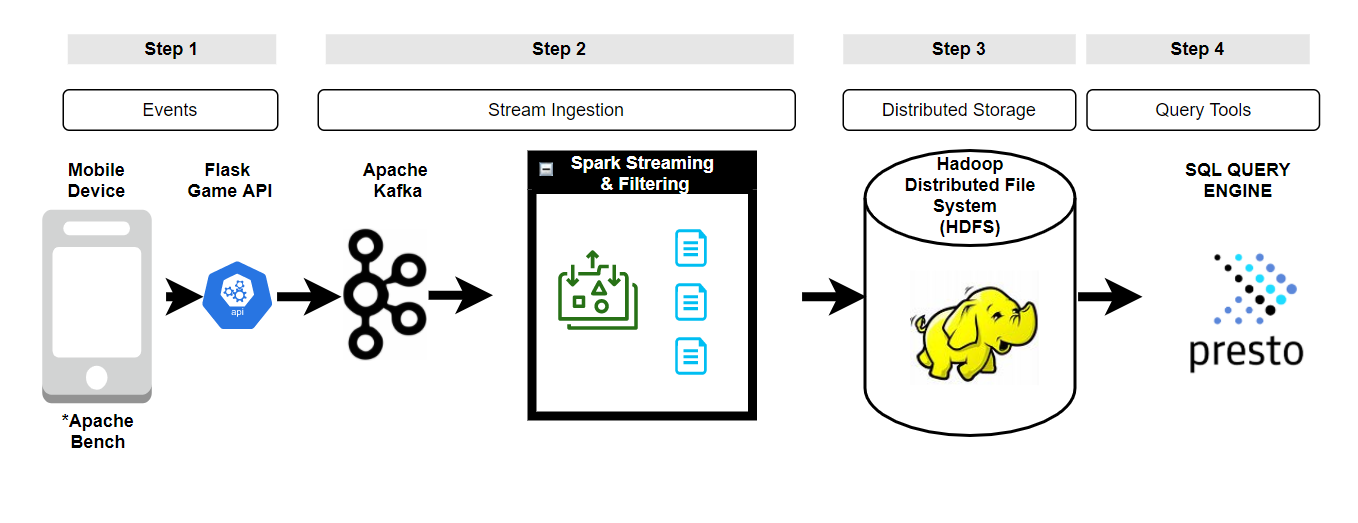

**Step 1** Use Apache Bench to generate events data (so that we can test the pipeline). Note: we are using Apache Bench to generate test mobile events. Flask will act as the Game API for events triggered via requests in Apache bench.

**Step 2** The game events are consumed using Kafka

**Step 3** Spark Streaming filters select event types from Kafka and land them on HDFS

**Step 4** Querying HDFS tables using Presto query engine


# Setup

This setup is using the latest docker image provided from the <b>midsw205</b> docker repository. A w205 directory was created within the virtual machine environment in the GCP instance. To connect Jupyter Notebook to the Spark container, Spark has an expose section in the docker-compose.yml file. Moreover, this Jupyter Notebook kernel was started from the command line in the virtual machine and was the ip address was updated to match the virtual machine.

Below is an outline of how my w205 directory is setup for this project.

```
w205/
├── _project-3-elizkhan/
│   ├── docker-compose.yml
│   ├── game_api.py
│   ├── write_events_stream.py
│   └── data_generator.sh

```

# Step 1 & 2: Initial Setup and Publish and Consume Messages with Kafka

Prior to executing the python script below, I spun up the containers for Zookeeper, Kafka, HDFS, Spark, Cloudera, and Presto using the docker-compose.yml file and created an "events" topic using published and consumed messages with Kafka.

The complete code that was executed in the command line scripts and annotations can be found below:

1. Going to directory where <b>docker-compose.yml</b>, <b>game_api.py</b> and <b> write_events_stream.py </b> are located
```bash
cd ~/w205/project-3-elizkhan
```
2. Bring up the <b>docker-compose</b> cluster
```bash 
docker-compose up -d 
```
3. Check open <b>Docker</b> containers to verify it is up and running
```bash
docker-compose ps
```
4. Check status of <b>zookeeper</b>
```bash
docker-compose logs zookeeper | grep -i binding
```
5. Create a kafka topic named <b>"events"</b>. This is a meaningful topic name that describes the contents of the data which is gameplay events.
```bash
docker-compose exec kafka kafka-topics --create --topic events --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```
6. Check kafka topic
```bash 
docker-compose exec kafka kafka-topics --describe --topic events --zookeeper zookeeper:32181
```
7. Set up to watch Kafka and make sure Kafka is consuming events
```bash
docker-compose exec mids kafkacat -C -b kafka:29092 -t events -o beginning
```
8. Start up Flask (via game_api.py which specifies the events and the specific requests and parameters that can be included)
```bash
docker-compose exec mids flask run --host=0.0.0.0
```
9. Execute <b> write_events_stream.py </b> script to read the stream events from Kafka and land into HDFS tables
```bash
docker-compose exec spark spark-submit /w205/write_events_stream.py
```
10. Use Apache Bench to generate synthetic mobile device events. This is executing a bash script that randomly generates synthetic game data. In this case, we are specifying 100 users and 1000 events (specified via the `-u` and `-n`). For additional information on how the script works please refer to the comments enclosed [here.](data_generator.sh) Note: `-b` uses Apache bench if you do not specify this it will default to the native `CURL` command to generate events.
```bash
./data_generator.sh -u 100 -e 9 -n 1000 -b
```
11. Create jupyter notebook instance within the <b>Spark</b> environment
```bash
docker-compose exec spark env PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --no-browser --port 8888 --ip 0.0.0.0 --allow-root' pyspark
```
12. Go to Cloudera Container to access Hive
```bash
 docker exec -it project-3-elizkhan_cloudera_1 hive
```
13. Create Hive Catalog for each table  
*Note: The SQL is formatted for readability purposes, it needs to be a single line to run in Hive. For complete list of hive catalog queries for all tables go to Step 4.*
```SQL
        create external table if not exists default.purchase_events 
        ( 
            event_ts timestamp, 
            userid string, 
            Host string, 
            event_type string, 
            item_type string,
            description string,
            amount_purchased int,
            price int 
        ) 
        stored as parquet location '/tmp/purchase_events'   
        tblproperties ("parquet.compress"="SNAPPY");
```
14. Start up the Presto Query Engine.  ***(Note: this was run after Spark transformations from this Jupyter notebook were complete)***

```bash
docker-compose exec presto presto --server presto:8080 --catalog hive --schema default
```
15. View existing tables using Presto to verify that everything works (For complete list of Presto queries, please see section 4). ***(Note: Presto queries were executed after Spark transformations from this Jupyter notebook were complete)***

``` bash
show tables;
```

Output from command line:

```
     Table       
------------------
 character_events 
 character_stats  
 guild_events     
 purchase_events  
(4 rows)
```

16. Shut down cluster executed ***(Note: this was run after Spark transformations and queries were executed from this Jupyter notebook were complete)***
```bash
docker-compose down
```

# Step 3:  Spark Streaming filtering events from Kafka  

The next step is to stream the real time events, transform them into a suitable table format, and land them in HDFS for querying. Please note that Step 3 is not executable code, but just a walkthrough of the write_events_stream.py that was executed via the command prompt. For the complete executable code please go here[write_events_stream.py].

## Data Import

In write_events_stream.py, we first subscribe to the kafka "events" topic stream and creates a new spark dataframe with Kafka schema.


``` python
raw_events = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:29092") \
    .option("subscribe", "events") \
    .load()
    
```

## Filtering Events

*Note: these are steps from the write_events_stream.py file*

Next, we use User Defined Functions for filtering the game events into four categories. 

1. Purchase Events (``is_purchase``): Gameplay events where the player is purchasing a sword, shield, or potion.
2. Character Events (``is_character_event``): Gameplay events where the player's character is gaining experience or progressing through the game.
3. Character Stats (``is_character_stat``): Gameplay events that change Health, Strength, Attack, etc. of a character such as Level Up and Taking a Potion.
4. Guild Event (``is_join_guild``): A gameplay event where a player becomes a member of a guild

``` python
@udf('boolean')
def is_purchase(event_as_json):
    """
    @function: This function uses a json to filter out records by purchase event type
    @param: Takes in extracted json data as a string
    @return: Returns a boolean value
    """    
    event = json.loads(event_as_json)
    if 'purchase' in event['event_type']:
        return True
    return False


@udf('boolean')
def is_character_event(event_as_json):
    """
    @function: This function uses a json to filter out records by character event type
    @param: Takes in extracted json data as a string
    @return: Returns a boolean value
    """    
    event = json.loads(event_as_json)
    if event['event_type'] == 'find_treasure' or event['event_type'] == 'enemy_attack' or event['event_type'] == 'defeat_enemy':
        return True
    return False

@udf('boolean')
def is_character_stat(event_as_json):
    """
    @function: This function uses a json to filter out records by character stat event type
    @param: Takes in extracted json data as a string
    @return: Returns a boolean value
    """    
    event = json.loads(event_as_json)
    if event['event_type'] == 'level_up' or event['event_type'] == 'take_potion':
        return True
    return False

@udf('boolean')
def is_join_guild(event_as_json):
    """
    @function: This function uses a json to filter out records by guild event type
    @param: Takes in extracted json data as a string
    @return: Returns a boolean value
    """   
    event = json.loads(event_as_json)
    if event['event_type'] == 'join_guild':
        return True
    return False
```



## Schema Definition

*Note: these are steps from the write_events_stream.py file*

We create user defined functions to create a schema defintion for each of the four tables to combine the `timestamp` with the events `value` data. The example below is for the purchase_events table.

This code snippet providing the schema for the purchase_events table

```python
def purchase_events_schema():
    """
    @function: This function provides the table schema for purchase events
    @param: None 
    @return: Returns the table schema for purchase events
    """  
    return StructType(
    [
        StructField('Accept', StringType(), True),
        StructField('Host', StringType(), True),
        StructField('User-Agent', StringType(), True),
        StructField('amount_purchased', LongType(), True),
        StructField('description', StringType(), True),
        StructField('event_type', StringType(), True),
        StructField('item_type', StringType(), True),
        StructField('price', LongType(), True),
        StructField('userid', StringType(), True)
    ]
)
```

## Filtering & Spark Transformations

*Note: these are steps from the write_events_stream.py file*

As mentioned previously, the raw events are filtered into the four categories above and cast to strings for further processing of the JSON file structure. Gameplay timestamps are also cast to a string as well.

We then read in the JSON formatted string using the provided schema and `from_json` to parse the string. Finally, we create a seperate spark DataFrame for the four types of events that were previously filtered from the Kafka queue. 

In each of our tables we will include the <b>userid</b> as the primary key which should be utilized by our data scientists to join table based on the different event types. The `timestamp` field is also selected from the base table as it allows us to get an idea of the players usage of the mobile game application.

## Final Transformations

*Note: these are steps from the write_events_stream.py file*

In the final step prior to landing the tables on HDFS, we select the relevant columns for each table and remove any duplicates by using distinct. The final tables available in HDFS to query via Presto will be as follows:

1. `purchase_events`: this table will include all purchase related events for gameplay items including swords, shields, and potions 
2. `character_events`: this table will include gameplay character events such as an enemy attack or defeating an enemy
3. `character_stats`: this table will include gameplay character events such as an enemy attack or defeating an enemy
4. `guild_events`: this table includes data about player memberships within the game

The final table structures will be as follows: 
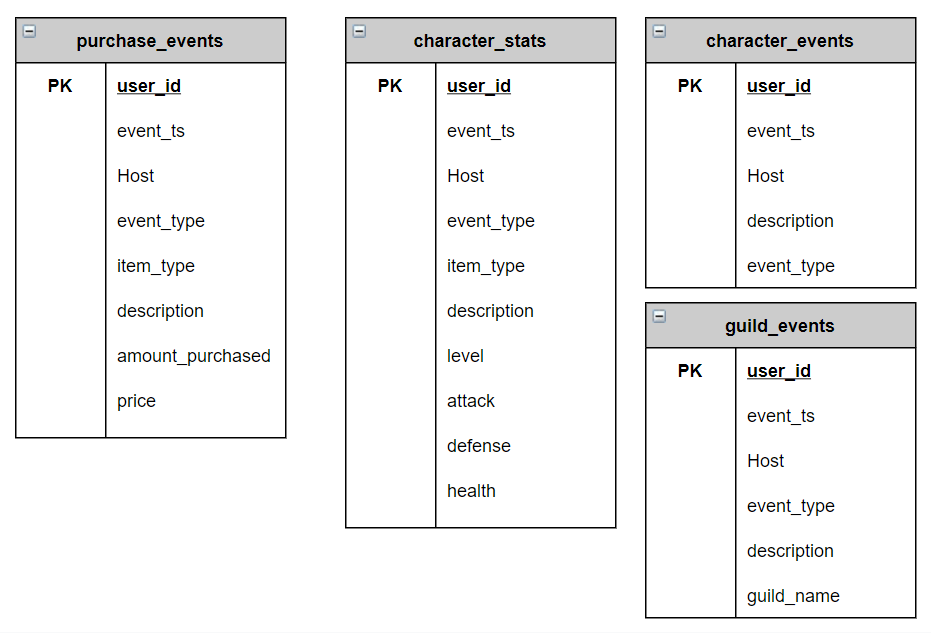

In [ ]:
# extracted_purchase_events.printSchema()

``` python
    purchases = raw_events \
        .filter(is_purchase(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          purchase_events_schema()).alias('json')) \
        .select('timestamp', 'json.*') \
        .select( \
                  F.from_utc_timestamp(F.col('timestamp'),'GMT').alias('event_ts') \
                 ,F.col('userid') \
                 ,F.col('Host') \
                 ,F.col('event_type') \
                 ,F.col('item_type') \
                 ,F.col('description') \
                 ,F.col('amount_purchased') \
                 ,F.col('price') \
                ) \
        .distinct()
```

# Step 3 (Continued) Write dataframe to HDFS and Create Catalog in Hive for Querying in Presto

*Note: these are steps from the write_events_stream.py file*


Finally, we write each of the four spark DataFrames in parquet format to HDFS. Then we register the temp table and create a a metadata catalog in Hive for querying via Presto.

Te snippet of code below creates the `purchase_events` table in HDFS.

```python
    sink_purchases = purchases \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_purchase_events") \
        .option("path", "/tmp/purchase_events") \
        .trigger(processingTime="10 seconds") \
        .start()
    
    sink_purchases.awaitTermination()
```

*Note: The ***awaitTermination*** waits for the users exit signal which is ctrl+c or else it will keep pulling Kafka and load to HDFS*

In [6]:
purchase_events_df = spark.read.parquet("/tmp/purchase_events")

In [7]:
purchase_events_df.show(1,truncate=False)

+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+
|event_ts               |userid     |Host                 |event_type    |item_type|description           |amount_purchased|price|
+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+
|2021-08-06 03:08:55.631|'user-0053'|user-0053.comcast.com|purchase_sword|sword    |very sharp steel sword|6               |100  |
+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+
only showing top 1 row



In [8]:
purchase_events_df.registerTempTable('purchase_events')

In [13]:
spark.sql("""
            select *
            from purchase_events
            Limit 1
          """).show(truncate=False)

+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+
|event_ts               |userid     |Host                 |event_type    |item_type|description           |amount_purchased|price|
+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+
|2021-08-06 03:08:55.631|'user-0053'|user-0053.comcast.com|purchase_sword|sword    |very sharp steel sword|6               |100  |
+-----------------------+-----------+---------------------+--------------+---------+----------------------+----------------+-----+



In [11]:
purchase_events_df.printSchema()

root
 |-- event_ts: timestamp (nullable = true)
 |-- userid: string (nullable = true)
 |-- Host: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- amount_purchased: long (nullable = true)
 |-- price: long (nullable = true)



In [12]:
purchase_events_df.columns

['event_ts',
 'userid',
 'Host',
 'event_type',
 'item_type',
 'description',
 'amount_purchased',
 'price']

Create <b>purchase_stats</b> metadata catalog by running this in Hive. 
*Note: it is formatted for readability purposes will work in Hive as a single line only.*

``` sql
  create external table if not exists default.purchase_events 
    ( 
        event_ts timestamp, 
        userid string, 
        Host string, 
        event_type string, 
        item_type string,
        description string,
        amount_purchased int,
        price int 
    ) 
    stored as parquet location '/tmp/purchase_events'   tblproperties ("parquet.compress"="SNAPPY");
```

This creates the `character_events` table.

In [19]:
character_events_df = spark.read.parquet("/tmp/character_events")

In [38]:
character_events_df.registerTempTable('character_events')

In [20]:
character_events_df.printSchema()

root
 |-- event_ts: timestamp (nullable = true)
 |-- userid: string (nullable = true)
 |-- Host: string (nullable = true)
 |-- description: string (nullable = true)
 |-- event_type: string (nullable = true)



In [21]:
character_events_df.columns

['event_ts', 'userid', 'Host', 'description', 'event_type']

Create <b>character_events</b> metadata catalog by running this in Hive. 
*Note: it is formatted for readability purposes will work in Hive as a single line only.*

``` sql
create external table if not exists default.character_events (
    event_ts timestamp, 
    userid string, 
    Host string,
    description string,
    event_type string
) 
stored as parquet location '/tmp/character_events'   
tblproperties ("parquet.compress"="SNAPPY");
```

This creates the `character_stats` table.

In [22]:
character_stats_df = spark.read.parquet("/tmp/character_stats")

In [36]:
character_stats_df.registerTempTable('character_stats')

In [23]:
character_stats_df.printSchema()

root
 |-- event_ts: timestamp (nullable = true)
 |-- userid: string (nullable = true)
 |-- Host: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- level: long (nullable = true)
 |-- attack: long (nullable = true)
 |-- defense: long (nullable = true)
 |-- health: long (nullable = true)



In [24]:
character_stats_df.columns

['event_ts',
 'userid',
 'Host',
 'event_type',
 'description',
 'level',
 'attack',
 'defense',
 'health']

Create <b>character_stats</b> metadata catalog by running this in Hive. 
*Note: it is formatted for readability purposes will work in Hive as a single line only.*

``` sql
create external table if not exists default.character_stats (
     event_ts timestamp,
     userid string,
     Host string,
     event_type string,
     description string,
     level int,
     attack int,
     defense int,
     health int 
) 
stored as parquet location '/tmp/character_stats'   
tblproperties ("parquet.compress"="SNAPPY");
```

This create the `guild events` table

In [25]:
guild_events_df = spark.read.parquet("/tmp/guild_events")

In [37]:
guild_events_df.registerTempTable('guild_events')

In [26]:
guild_events_df.printSchema()

root
 |-- event_ts: timestamp (nullable = true)
 |-- userid: string (nullable = true)
 |-- Host: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- guild_name: string (nullable = true)



Create <b>guild_events</b> metadata catalog by running this in Hive. 
*Note: it is formatted for readability purposes will work in Hive as a single line only.*

``` sql
create external table if not exists default.guild_events (
     event_ts timestamp,
     userid string,
     Host string,
     event_type string,
     description string,
     guild_name string
) 
stored as parquet location '/tmp/guild_events'   
tblproperties ("parquet.compress"="SNAPPY");
```

We check to see if the tables are listed in the catalog. We can now proceed with running the queries to address key business questions. *Optional Code to run*

In [5]:
# spark.catalog.listTables()

# Step 4 Querying HDFS tables using Spark & the Presto query engine

## Business questions answered

Below are the Spark/ Presto queries that answer the key gameplay business questions above.

1. How many swords, shields, and potions were purchased?

> There were **641** swords, **324** shields, and **4789** potions purchased.

Query script for Presto:

``` sql
SELECT event_type,
       sum(amount_purchased) as ttl_purchased
FROM   purchase_events
GROUP  BY event_type; 
```

Command Line Output:

```
presto:default> SELECT event_type,
             ->        sum(amount_purchased) as ttl_purchased
             -> FROM   purchase_events
             -> GROUP  BY event_type;
   event_type    | ttl_purchased 
-----------------+---------------
 purchase_potion |          4789
 purchase_shield |           324 
 purchase_sword  |           641
(3 rows)
```


In [27]:
q1_query = """
               SELECT event_type,
                   sum(amount_purchased) as ttl_purchased
               FROM   purchase_events
               GROUP  BY event_type 
           """

In [46]:
spark.sql(q1_query).show(truncate=False)

+---------------+-------------+
|event_type     |ttl_purchased|
+---------------+-------------+
|purchase_sword |641          |
|purchase_potion|4789         |
|purchase_shield|324          |
+---------------+-------------+



2. How many members are in each guild?

> There are **49** members in the 'Game of Thrones' guild, **50** members in 'Knights of the Round Table' guild, and **42** members in 'Castle of Rock' guild.

SQL script for Presto:

``` sql
SELECT guild_name,
       Count(DISTINCT userid)
FROM   guild_events
GROUP  BY guild_name; 
```

Command Line Output:

```
presto:default> SELECT guild_name,
             ->        Count(DISTINCT userid)
             -> FROM   guild_events
             -> GROUP  BY guild_name;
         guild_name         | _col1 
----------------------------+-------
 'Castle of Rock'           |    42 
 'Game of Thrones'          |    49 
 Knights of the Round Table |    50 
(3 rows)
```

In [29]:
q2_query = """
              SELECT guild_name,
                  Count(DISTINCT userid)
              FROM   guild_events
              GROUP  BY guild_name 
            """

In [39]:
spark.sql(q2_query).show(truncate=False)

+--------------------------+----------------------+
|guild_name                |count(DISTINCT userid)|
+--------------------------+----------------------+
|'Game of Thrones'         |49                    |
|Knights of the Round Table|50                    |
|'Castle of Rock'          |42                    |
+--------------------------+----------------------+



3. What is are the levels of the top 10 players?

> **'user-0078'** is at the highest player level at **8**. See printout below for the highest levels of the top 10 players.

SQL Script for Presto:
``` sql
SELECT userid,
       Sum(level) AS player_level
FROM   character_stats
GROUP  BY userid
ORDER  BY Sum(level) DESC
LIMIT  10;
```

Command Line Output:

```
presto:default> SELECT userid,
             ->        Sum(level) AS player_level
             -> FROM   character_stats
             -> GROUP  BY userid
             -> ORDER  BY Sum(level) DESC
             -> LIMIT  10;
   userid    | player_level 
-------------+--------------
 'user-0078' |            8 
 'user-0074' |            6 
 'user-004'  |            6 
 'user-0047' |            5 
 'user-0012' |            5 
 'user-0099' |            5 
 'user-0087' |            5 
 'user-0081' |            5 
 'user-0062' |            4 
 'user-0088' |            4 
(10 rows)
```

In [40]:
q3_query = """
              SELECT userid,
                  Sum(level) AS player_level
              FROM   character_stats
              GROUP BY userid
              ORDER  BY Sum(level) DESC
              LIMIT  10 
           """

In [41]:
spark.sql(q3_query).show(truncate=False)

+-----------+------------+
|userid     |player_level|
+-----------+------------+
|'user-0078'|8           |
|'user-0074'|6           |
|'user-004' |6           |
|'user-0087'|5           |
|'user-0099'|5           |
|'user-0081'|5           |
|'user-0012'|5           |
|'user-0047'|5           |
|'user-0038'|4           |
|'user-0014'|4           |
+-----------+------------+



4. How many enemies did a player defeat?

> **'user-0046'** and multiple other users defeated the most enemies at **6**, see printout below for additonal details.

SQL Script for Presto:

``` sql
SELECT userid,
    Count(*) AS num_defeated
FROM   character_events
WHERE  event_type ='defeat_enemy'
GROUP  BY userid
ORDER  BY count(*) DESC
LIMIT  10;
```

Command Line Output:

```
presto:default> SELECT userid,
             ->     Count(*) AS num_defeated
             -> FROM   character_events
             -> WHERE  event_type ='defeat_enemy'
             -> GROUP  BY userid
             -> ORDER  BY count(*) DESC
             -> LIMIT  10;
   userid    | num_defeated 
-------------+--------------
 'user-0046' |            6 
 'user-0012' |            6 
 'user-0035' |            6 
 'user-0083' |            5 
 'user-0045' |            5 
 'user-009'  |            5 
 'user-0080' |            5 
 'user-0082' |            5 
 'user-0078' |            5 
 'user-0063' |            5 
(10 rows)
```

In [42]:
q4_query = """
              SELECT userid,
                  Count(event_type) AS num_defeated
              FROM   character_events
              WHERE  event_type ='defeat_enemy'
              GROUP  BY userid
              ORDER BY count(*) DESC
              LIMIT  10 
           """

spark.sql(q4_query).show(truncate=False)

+-----------+------------+
|userid     |num_defeated|
+-----------+------------+
|'user-0035'|6           |
|'user-0046'|6           |
|'user-0012'|6           |
|'user-0083'|5           |
|'user-0078'|5           |
|'user-0082'|5           |
|'user-0063'|5           |
|'user-0080'|5           |
|'user-009' |5           |
|'user-0045'|5           |
+-----------+------------+



5. Which player used the most potions?

> **'user-0012'** used the most potions at **7**.

SQL Script for Presto:

```sql
SELECT userid,
    Count(*) AS potions_used
FROM   character_stats
WHERE  event_type ='take_potion'
GROUP  BY userid
ORDER  BY count(*) DESC
LIMIT  1;
```


Command Line Output:

```
presto:default> SELECT userid,
             ->     Count(*) AS potions_used
             -> FROM   character_stats
             -> WHERE  event_type ='take_potion'
             -> GROUP  BY userid
             -> ORDER  BY count(*) DESC
             -> LIMIT  1;
   userid    | potions_used 
-------------+--------------
 'user-0012' |            7 
(1 row)
```

In [43]:
q5_query = """
              SELECT userid,
                  Count(*) AS potions_used
              FROM   character_stats
              WHERE  event_type ='take_potion'
              GROUP  BY userid
              ORDER BY count(*) DESC
              LIMIT  1
           """

spark.sql(q5_query).show(truncate=False)

+-----------+------------+
|userid     |potions_used|
+-----------+------------+
|'user-0012'|7           |
+-----------+------------+



6) Which player found the most treasures?

> **'user-0076'** found the most treasures at **8**.

SQL Script for Presto:

```sql
SELECT userid,
       Count(*) AS treasures_found
FROM   character_events
WHERE  event_type ='find_treasure'
GROUP  BY userid
ORDER  BY count(*) DESC
LIMIT  10;
```


Command Line Output:

```
presto:default> SELECT userid,
             ->        Count(*) AS treasures_found
             -> FROM   character_events
             -> WHERE  event_type ='find_treasure'
             -> GROUP  BY userid
             -> ORDER  BY count(*) DESC
             -> LIMIT  10;
   userid    | treasures_found 
-------------+-----------------
 'user-0076' |               8 
 'user-0023' |               7 
 'user-0028' |               6 
 'user-0080' |               6 
 'user-0019' |               5 
 'user-0065' |               5 
 'user-0092' |               5 
 'user-009'  |               5 
 'user-0038' |               5 
 'user-0034' |               5 
(10 rows)
```

In [44]:
q6_query = """
              SELECT userid,
                     Count(*) AS treasures_found
              FROM   character_events
              WHERE  event_type ='find_treasure'
              GROUP  BY userid
              ORDER  BY count(*) DESC
              LIMIT  10 
           """

spark.sql(q6_query).show(truncate=False)

+-----------+---------------+
|userid     |treasures_found|
+-----------+---------------+
|'user-0076'|8              |
|'user-0023'|7              |
|'user-0028'|6              |
|'user-0080'|6              |
|'user-0019'|5              |
|'user-0060'|5              |
|'user-009' |5              |
|'user-0092'|5              |
|'user-0038'|5              |
|'user-0034'|5              |
+-----------+---------------+



7) How many players were attacked by an enemy?

> **91** players were attacked by an enemy.

SQL Script for Presto:

```sql
SELECT count(distinct userid) as users_attacked_by_enemy
FROM   character_events
WHERE  event_type ='enemy_attack';
```

Command Line Output:

```
presto:default> SELECT count(distinct userid) as users_attacked_by_enemy
             -> FROM   character_events
             -> WHERE  event_type ='enemy_attack';
 users_attacked_by_enemy 
-------------------------
                      91 
(1 row)
```

In [45]:
q7_query = """
              SELECT count(distinct userid) as users_attacked_by_enemy
              FROM   character_events
              WHERE  event_type ='enemy_attack'
           """


spark.sql(q7_query).show(truncate=False)

+-----------------------+
|users_attacked_by_enemy|
+-----------------------+
|91                     |
+-----------------------+



# Section 4 Continued - Reporting

In the final part of the project we will create a gameplay reports which will include the `Player Standings`, `Player Purchases Report`, and `Guild Membership`. Here we start by converting queries to Pandas DataFrames to create a report printout. 

Although the data is synthetic, the reporting capabilities can still be demonstrated. From these example reports, we will query summary information from various HDFS tables via Spark and create Pandas dataframes to report out daily findings.

The DataFrame reports could be exported as an excel file or pdf if the future, but for the purposes of this exercise we will utilize Pandas dataframes a pseudo report.



First we create the `Player Standings Report` which shows which players are the leading the game in terms of player stats.

In [47]:
player_standings_query = """
                            SELECT userid,
                                Sum(level) AS level,
                                Sum(attack) as total_attack,
                                Sum(defense) as total_defense,
                                Sum(health) as total_health
                            FROM   character_stats
                            GROUP  BY userid
                            ORDER  BY Sum(level) DESC
                         """


player_standings = spark.sql(player_standings_query).toPandas()

Next we create a `Player Purchases Report` which shows all the purchases players made throughout the game. This could be used to inform our business decisions about which virtual game items we could use generate revenue from our game players using in app purchases.

In [49]:
player_purchases_query = """
                            SELECT userid,
                                Sum(case when item_type ='sword' then amount_purchased else 0 end) AS sword_purchases,
                                Sum(case when item_type ='shield' then amount_purchased else 0 end) AS shield_purchases,
                                Sum(case when item_type ='potion' then amount_purchased else 0 end) AS potion_purchases
                            FROM   purchase_events
                            GROUP  BY userid
                         """


player_purchases = spark.sql(player_purchases_query).toPandas()

Finally we create the `Guild Membership Report` which shows how many players are part of each guild. From this report identify the most popular guilds and use to target guilds with relevant game related content.

In [50]:
guild_membership_query =  """
                              SELECT guild_name,
                                  Count(DISTINCT userid) as members
                              FROM   guild_events
                              GROUP  BY guild_name 
                          """


guild_membership = spark.sql(guild_membership_query).toPandas()

The user defined function below formats the Pandas DataFrame into a format suitable for reporting. This includes printing out a title and formatting table headers. Note: The max numbers are highlighted in yellow.

In [53]:
# Import standard libraries
from datetime import datetime
import numpy as np
import pandas as pd
from datetime import date

In [54]:
def format_df(df, title):
    """
    @function: This function uses a formats a Pandas Dataframe and prints out the title
    @param: Takes in a DataFrame and a title string
    @return: Returns a formatted DataFrame
    """  
    today = date.today()
    print(title+' Report As of '+ today.strftime("%B %d, %Y"))
    return df \
    .style.set_table_styles( \
       [{
           'selector': 'th',
           'props': [('background-color', 'lightgrey')]
       }]) \
    .set_properties(**{'background-color':'white'}) \
    .highlight_max(axis=0)


Using the function above we create the final business report DataFrame. Note: I am only using first 10 records for display purposes.

# Example of Daily Reports

These reports can be exported to an excel, csv, or html format depending on the needs of our business.

In [55]:
format_df(player_standings.head(10), 'Player Standings')

Player Standings Report As of August 06, 2021


,userid,level,total_attack,total_defense,total_health
0,'user-0078',8,1600,1400,870
1,'user-004',6,1200,1050,710
2,'user-0074',6,1200,1050,630
3,'user-0081',5,1000,875,520
4,'user-0087',5,1000,875,580
5,'user-0099',5,1000,875,520
6,'user-0047',5,1000,875,560
7,'user-0012',5,1000,875,660
8,'user-0089',4,800,700,400
9,'user-0034',4,800,700,400


In [56]:
format_df(player_purchases.head(10), 'Player Purchases')

Player Purchases Report As of August 06, 2021


,userid,sword_purchases,shield_purchases,potion_purchases
0,'user-0030',10,7,126
1,'user-0034',2,0,80
2,'user-0089',2,0,0
3,'user-009',0,1,0
4,'user-004',10,5,112
5,'user-0060',3,0,0
6,'user-0092',7,0,0
7,'user-0011',2,4,0
8,'user-0069',9,3,38
9,'user-0067',1,2,66


In [57]:
format_df(guild_membership, 'Guild Membership')

Guild Membership Report As of August 06, 2021


,guild_name,members
0,'Game of Thrones',49
1,Knights of the Round Table,50
2,'Castle of Rock',42


# Next Steps and Considerations

The current pipeline is proof of concept end to end pipeline that handles minimal concurrent users. For the reporting requirements I am assuming that this would be either hourly or daily and require batch processing not real-time streaming. If real time reporting and analytics is necessary in the future we should leverage spark structured streaming windowing functions (such as hopping, session, sliding, and/or tumbling).

#### Some additional considerations that need to be are as follows:

1) The Flask API would need to be set up in such a way that it could handle concurrent users. There are peak times where a larger number of users may be playing the game at the same time where we need to design for better consistency and availability storage data model. We would also need to consider a larger compute (Virtual Machines) or distributed compute (Kubernetes) to handle the peak load in the production setting.

2) In order to compute a current player state in the game we would need to set up Redis or Cassandra storage to ensure we can report on the gameplay in Real-Time to meet sub-millisecond latency requirements in the report.